# Analyzing SAT Test Results for New York Schools

 As a Math Educator I prepare students for SAT general and SAT Math Subject tests for many years
    
 The efficacy of the test is still controversial issue, whether such tests unfair to certain groups. 
    This paper is an attempt to investigate dependence of SAT scores on different demographic factors such as race and gender, prosperity of neighborhoods where schools located. 

  New York City makes its data on high school SAT scores available 
online https://data.cityofnewyork.us/, as well as the demographics for each high school. We pick data in csv format from different pages of the website 
    We combined all these sources into a single data set before we can find correlations.

The files we used:

sat_results.csv - Data on SAT scores;

class_size.csv - Data on class size; 

demographics.csv - Data on demographics 

gaduation.csv - Data on graduation outcomes;

hs_directory.csv - A directory of high schools; 

survey_all.txt - Data on surveys from all schools 


# Read in the data

In [148]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [149]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

There are 5 boroughs in NY, there are different districts of the city, 
each school in NY has unique number which contains borough number as well.
So, we will use DBN as index column through all tables. 

In [150]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

We may eventually want to combine the three columns that contain SAT scores --
SAT Critical Reading Avg. Score, 
SAT Math Avg. Score, and 
SAT Writing Avg. Score -- into a single column to make the scores easier 
to analyze.
We need convert string columns with SAT results 
(SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg) 
into numeric ones to find out summary of them. 

Then, we'll parse the latitude and longitude coordinates for each school.
The field ‘Location 1’ contains geo coordinates for schools. We need to extract coordinates from parenthesis.  



In [151]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

We'll read each file into a pandas dataframe, and then store all of the 
dataframes in a dictionary. The name of the file is a key for the file with 
such a database. 
The DBN appears to be a unique ID for each school – this key is valid for 
most of the files. 

But we can see several rows with the same DBN. It means that the tables contain results for 
CORE COURSE (MS CORE and 9-12 ONLY) and Core Subject (MS CORE and 9-12 ONLY) for the same schools but different classes. We will calculate average for all subjects for each school (one DBN). 

For SAT score analysis we need only data from high schools ("09-12" column) so as the test to be taken in the final 12th grade.  


In [152]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

Except SAT, another state exam is AP text (Advanced Placement). 
There are several AP exams each corresponding to a school subject. 
Taking such exam helps student to receive college credit. The scale 
to estimate AP results is from 1 to 5, and only schools with special
funding can afford to hold it. 

We will explore do the AP test results correlate with SAT scores or not.



In [153]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

We merge data from several sources using LEFT and INNNER JOIN. We will assign data[‘sat_results’] to variable Combined and join other tables class_size, demographics, survey, and hs_directory to it:


In [154]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [155]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

So, we consolidate all needed data in one file Combined and ready to analyze it.

# Find correlations

We will use Pearson’s correlation r coefficient (from -1 to 1) to estimate 
correlation – how closely related two columns are. 
We used pd.DataFrame.corr() for finding correlation. The method returns 
a new dataframe where the index for each column and row is the name 
of column in the original data set.


In [156]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [157]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

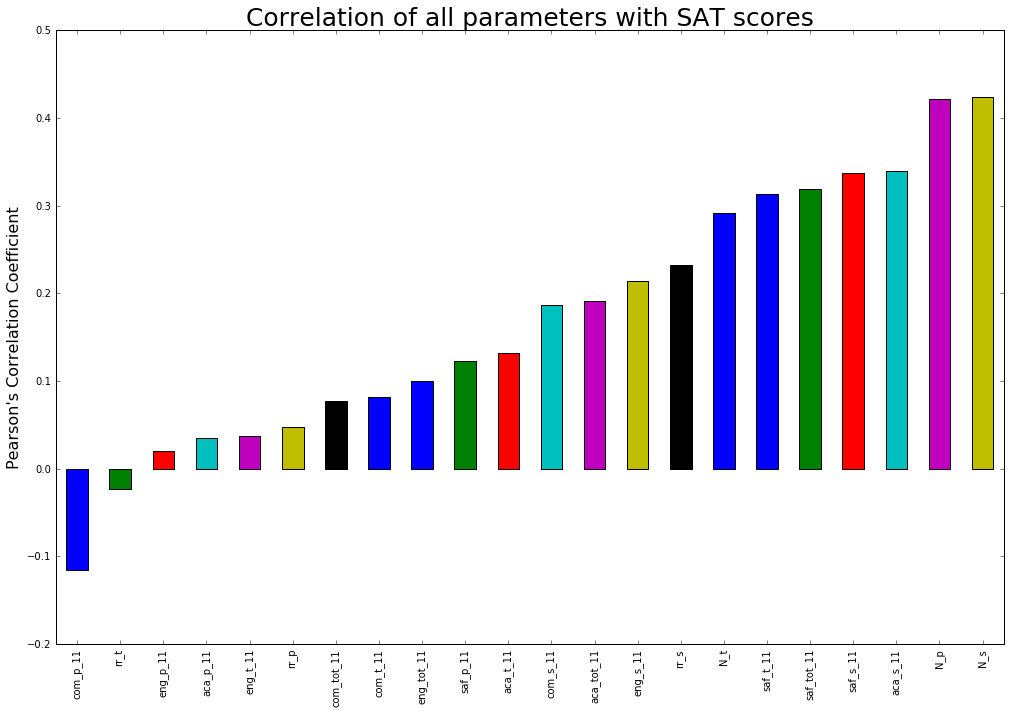

In [177]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

combined.corr()["sat_score"][survey_fields].sort_values().plot.bar(figsize = (17,11))

plt.title('Correlation of all parameters with SAT scores',fontsize = 25)
plt.ylabel("Pearson's Correlation Coefficient",  size=16)
plt.show()

It seems that teachers’ and students’ perception of safety (saf_t_11 and saf_s_11 columns) pretty well enough correlated with SAT scores. Let us check it and plot a scatter graph.

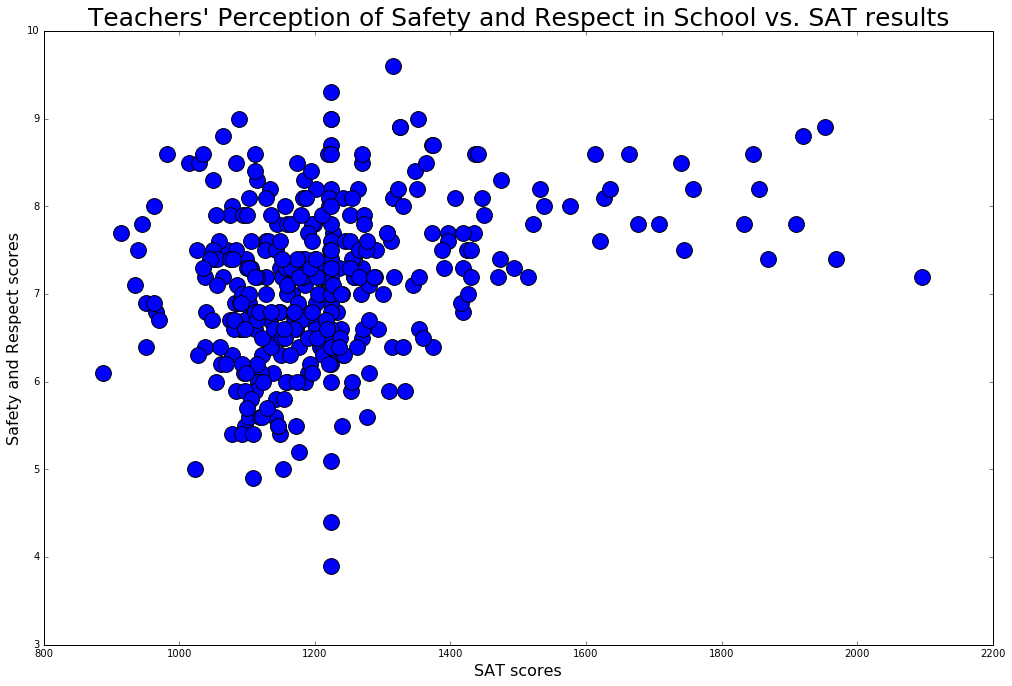

In [172]:
combined.plot.scatter(x='sat_score', y ='saf_t_11', s =250, figsize = (17,11))
plt.title("Teachers' Perception of Safety and Respect in School vs. SAT results",fontsize = 25)
plt.xlabel('SAT scores', size=16)
plt.ylabel('Safety and Respect scores', size=16)
plt.show()

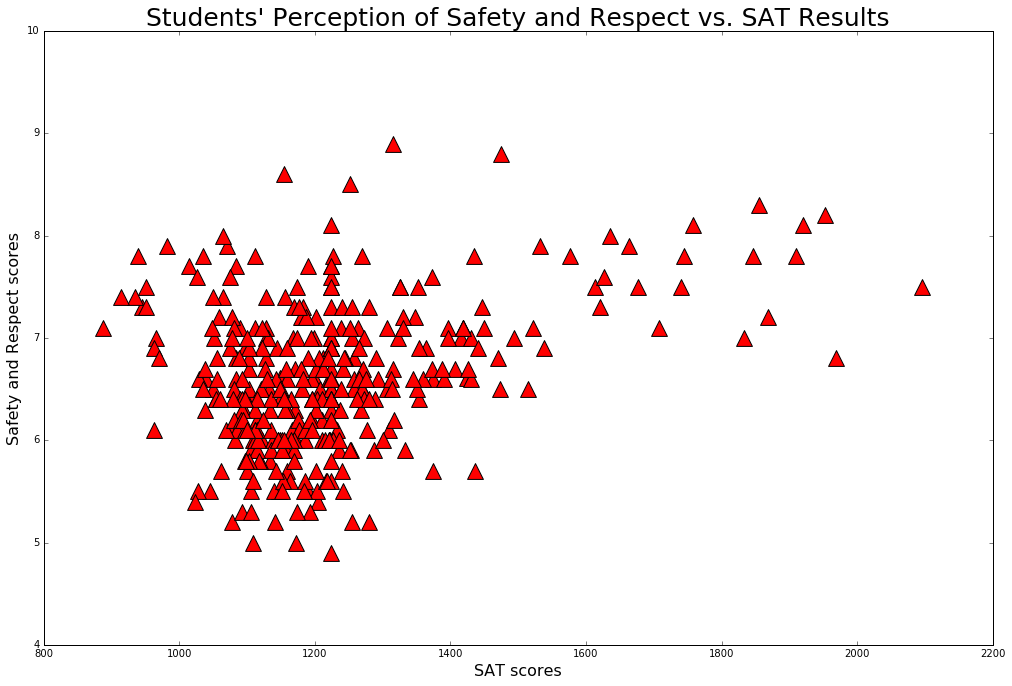

In [173]:
combined.plot.scatter(x='sat_score', y ='saf_s_11', color = 'r', marker='^', s = 250, figsize = (17,11))
plt.title("Students' Perception of Safety and Respect vs. SAT Results", fontsize = 25)
plt.xlabel('SAT scores', size=16)
plt.ylabel('Safety and Respect scores', size=16)
plt.show()

In [161]:
combined[['saf_s_11', 'saf_t_11']].groupby(by=combined["boro"]).mean()

,saf_s_11,saf_t_11
boro,,
Bronx,6.606577,7.026882
Brooklyn,6.370755,6.985849
Manhattan,6.831370,7.287778
Queens,6.721875,7.365625
Staten Island,6.530000,7.210000


Not surprisingly, the most affluent part of NY - Manhattan - has the highest safety score.

# Correlation of racial differences and SAT perfomance. 

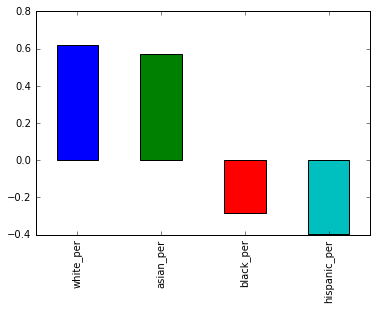

In [162]:
racial = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()["sat_score"][racial].plot.bar()
plt.show()


According to the data, white and Asian students averagely have more impressive SAT performance.

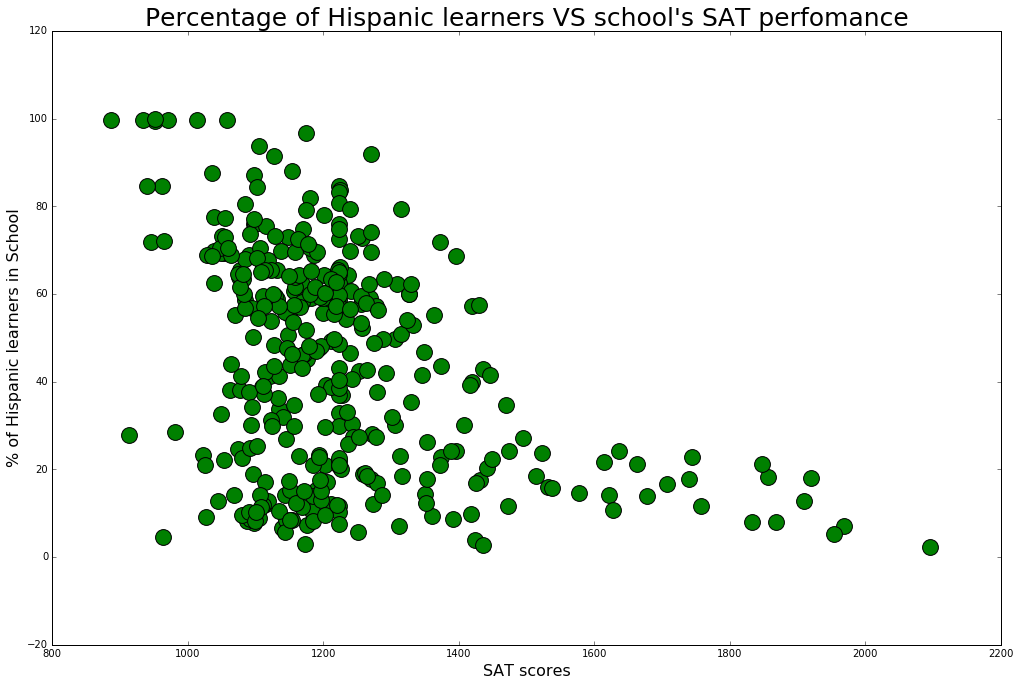

In [174]:
combined.plot.scatter(x='sat_score', y ='hispanic_per', color='g', s = 250, figsize = (17,11))
plt.title("Percentage of Hispanic learners VS school's SAT perfomance",fontsize=25)
plt.xlabel('SAT scores', size=16)
plt.ylabel('% of Hispanic learners in School', size=16)

plt.show()

We can see very strong negative correlation between presence of hispanic
learners and SAT perfomance. 
Let us choose schools with high Hispanic presence and low SAT performance and try to find out what is wrong with such schools:

In [164]:
print(combined['SCHOOL NAME'][combined['hispanic_per']>95.0])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


There is a lot of immigrants in the schools listed above, their students still in the process of learning English, it explains comparatively low SAT scores.

Let us explore schools with high SAT results and low hispanic presence:

In [165]:
print(combined['SCHOOL NAME'][(combined['hispanic_per']<10.0) & 
      (combined['sat_score']>1800)])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object



These schools are mostly for gifted students, 
not for everyone, one for those who have passed an entrance exam.


# How gender correlates with SAT perfomance. 

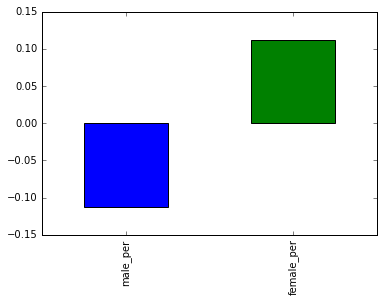

In [166]:
gender = ['male_per', 'female_per']
combined.corr()['sat_score'][gender].plot.bar()
plt.show()

Girls are usually more accurate and managebale, so they show better SAT results.

In [167]:
combined.plot.scatter(x='sat_score', y ='female_per', color='r',figsize = (17,11))
plt.title("Percentage of girls in school 
          VS school's SAT perfomance", fontsize =25)

plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-167-4ca0689627eb>, line 2)

In [ ]:
combined.plot.scatter(x='sat_score', y ='male_per',figsize = (17,11))
plt.title("Percentage of boys in school VS school's SAT perfomance",fontsize = 25)
plt.show()

In [ ]:
print(combined['SCHOOL NAME'][(combined['female_per']>65.0) & 
      (combined['sat_score']>1700)])

These schools have very high standards. 
Scatter graphs show us ABSENCE of correlation 
between the number of female student and SAT performance.


Let us calculate percentage of AP takers among students in each school.
If SAT exam is obligatory for everyone, AP exam is supposed only for  
who intended to continue study in Universities or other higher educational institutions?


In [ ]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per', y ='sat_score', color = 'black',marker='*',figsize = (17,11))
plt.title('Percentage of AP takers in school VS school avarage SAT perfomance',fontsize = 25)
plt.xlim(-0.1,1.0)
plt.ylim(800,2200)
plt.show()



It is rather strange, but there is no strong correlation between number of AP takers in school and higher SAT results, but such tendency is still present.


Let us explore is any correlation between Communication scores based on students, teachers and parents' responses with school's average SAT Scores.

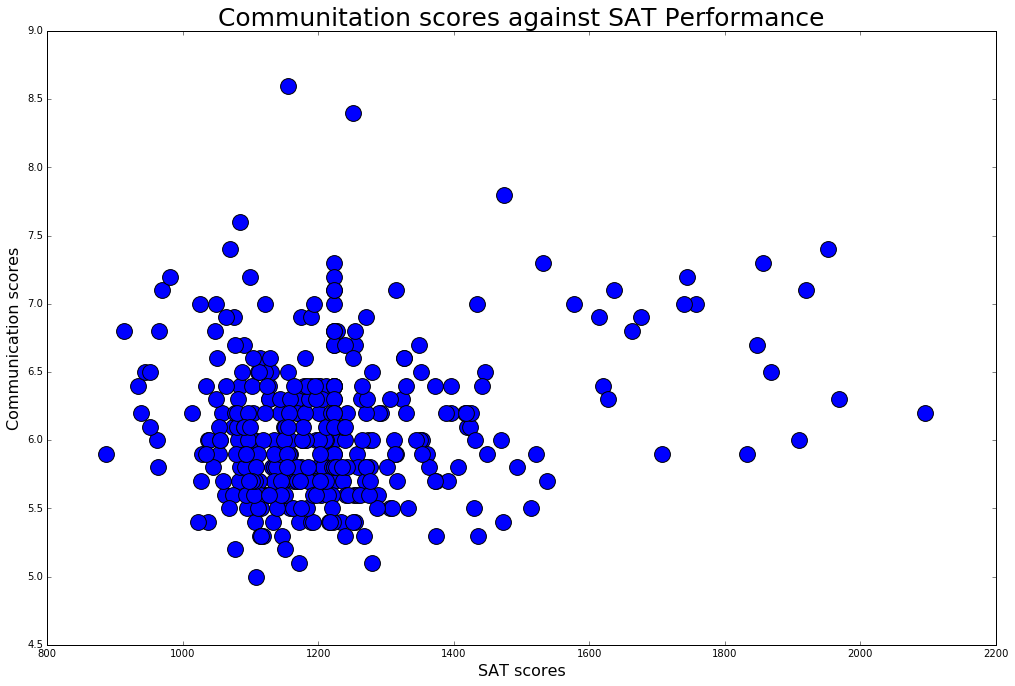

In [175]:
sur_field_other = ["com_p_11", "com_t_11", "com_s_11", "com_tot_11"]

combined.plot.scatter(x="sat_score", y = "com_s_11",figsize = (17,11), s = 250)
plt.title("Communitation scores against SAT Performance", fontsize = 25)
plt.xlabel('SAT scores', size=16)
plt.ylabel('Communication scores', size=16)
plt.show()


In [ ]:
The communication score does not correlate with SAT Performance at all. 
It is strange, I would expect a negative correlation.  


In [ ]:
combined.corr()["com_s_11"][["com_t_11", "com_p_11"]

We can see from the data that opinions of parents and students are connected rather strongly, but we cannot see the same coherence of Students against Teachers' opinions.

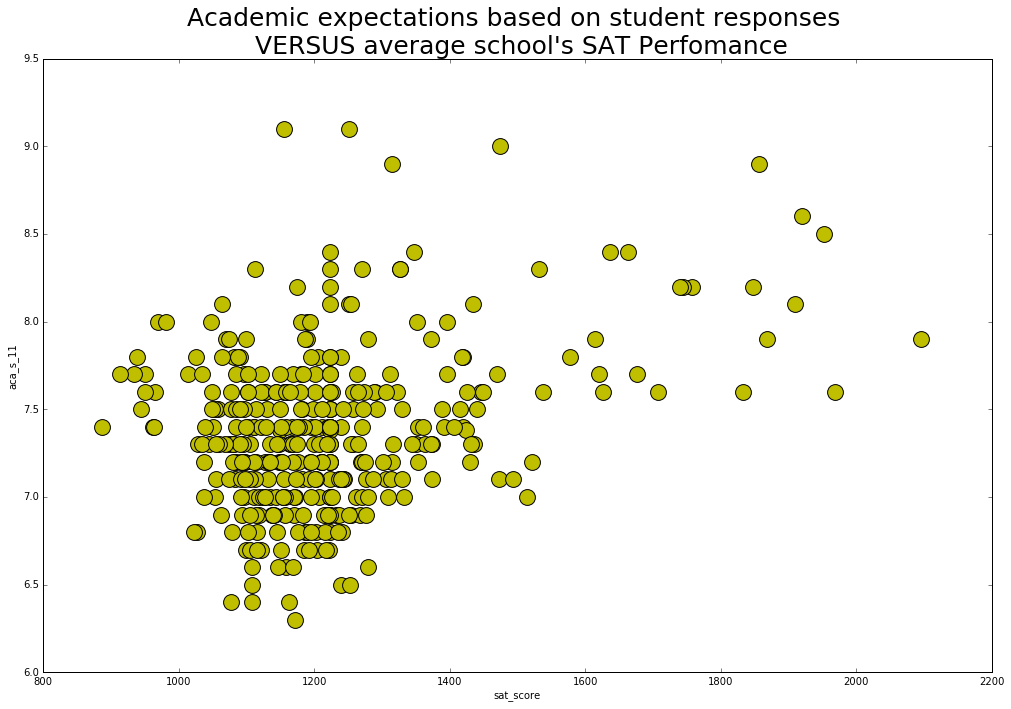

aca_s_11    0.339435
aca_p_11    0.035155
aca_t_11    0.132348
Name: sat_score, dtype: float64

In [178]:
sur_field_other = ["aca_p_11", "aca_t_11", "aca_s_11", "aca_tot_11"]

combined.plot.scatter(x="sat_score", y = "aca_s_11", figsize = (17,11), s = 250, color='y')
plt.title("Academic expectations based on student responses \n VERSUS average school's SAT Perfomance", fontsize = 25)
plt.show()
combined.corr()["sat_score"][["aca_s_11", "aca_p_11", 'aca_t_11']]


In [ ]:
combined.corr()["sat_score"][["aca_s_11", "aca_p_11", "aca_t_11"]].plot.bar()
plt.title('Correlation of Academic expectations with SAT Performance')
plt.show()

Surprisingly, the final SAT results showed to be most correlated with students' 
expectations than teachers' and parents' ones. Students' estimation of readiness 
for the test is shown to be the most accurate one.



# Summary

Our exploration shows that schools where prevail quantity of girls over number of boys show slightly better results in SAT, schools with more AP testers have better average SAT performance. Safety and engagements are positive factors for success in test. But more crucial conclusion that there is a gap between demographic groups in test performance.  

I have a lot of foreign students who are not the native English speakers, and the study shows that SAT challenging not for my students only, 
there is a tendency that schools with more presence of immigrants averagely 
show poorer SAT scores.
